In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import argparse
import os
import pickle
import random
import time
import sys
import datetime
import copy
import numpy as np
import chainer
from chainer import optimizers
from chainer import cuda
from chainer import serializers
import tensorflow as tf
import multiprocessing as mp
import chainer.functions as F
import chainer.links as L

sys.path.append('../../chainer-SeqGAN/')

from models import SeqGAN, TextCNN, SeqEncoder
from optimizer_hook import NamedWeightDecay

os.environ['PATH'] += ':/usr/local/cuda/bin'

parser = argparse.ArgumentParser()
parser.add_argument("--out", default='')
parser.add_argument("--gen", default='')
parser.add_argument("--dis", default='')
parser.add_argument("--enc", default='')
parser.add_argument('--gpu', '-g', type=int, default=0)
parser.add_argument('--parallel', '-p', default=0, type=int)

#  Generator  Hyper-parameters
parser.add_argument("--gen_emb_dim", type=int, default=256)
parser.add_argument("--gen_hidden_dim", type=int, default=256)
parser.add_argument("--gen_grad_clip", type=int, default=5)
parser.add_argument("--gen_lr", type=float, default=1e-3)
parser.add_argument("--num_lstm_layer", type=int, default=1)
parser.add_argument("--no-dropout", dest='dropout', action='store_false', default=True)

#  Training  Hyper-parameters
parser.add_argument("--batch_size", type=int, default=100)
parser.add_argument("--total_epoch", type=int, default=800)
parser.add_argument("--gen_pretrain_epoch", type=int, default=100)

parser.add_argument("--vae", dest='vae', action='store_true', default=False)

args, _ = parser.parse_known_args()


In [2]:
with open('nico_comment_processed.dat', 'rb') as f:
    train_comment_data, test_comment_data, train_tag_data, test_tag_data, vocab, tag_id = pickle.load(f)
train_num = len(train_comment_data)
test_num = len(test_comment_data)
vocab_size = 3000
seq_length = 20
start_token = 0

In [3]:
out_dir = 'runs_vrae/'
emb_dim = 256
tag_dim = 0

In [4]:
# generator
generator = SeqGAN(vocab_size=vocab_size, emb_dim=emb_dim, hidden_dim=emb_dim,
                   sequence_length=seq_length, start_token=start_token, lstm_layer=args.num_lstm_layer,
                   dropout=args.dropout, encoder=None, tag_dim=tag_dim).to_gpu()
serializers.load_hdf5('./gen_pretrain_50.model'.format(out_dir), generator)

/home/keisuke_fukuta/.pyenv/versions/anaconda3-4.1.0/lib/python3.5/site-packages/chainer/cuda.py:90: UserWarning: cuDNN is not enabled.
Please reinstall chainer after you install cudnn
(see https://github.com/pfnet/chainer#installation).
  'cuDNN is not enabled.\n'


In [5]:
# encoder
encoder = SeqEncoder(vocab_size=vocab_size, emb_dim=emb_dim, hidden_dim=emb_dim,
                     sequence_length=seq_length, tag_num=tag_dim).to_gpu()

serializers.load_hdf5('enc_pretrain_50.model'.format(out_dir), encoder)

# generator
generator = SeqGAN(vocab_size=vocab_size, emb_dim=emb_dim, hidden_dim=emb_dim,
                   sequence_length=seq_length, start_token=start_token, lstm_layer=args.num_lstm_layer,
                   dropout=args.dropout, encoder=encoder, tag_dim=tag_dim).to_gpu()
serializers.load_hdf5('gen_pretrain_50.model'.format(out_dir), generator)


In [7]:
for t in tag_id:
    print(t)

例のアレ
エンタメ・音楽
科学・技術
生活・一般・スポ
政治
アニメ・ゲーム・絵


In [6]:
def to_sentence(sentences):
    return [''.join([vocab[w] for w in x]) for i, x in enumerate(sentences)]
         

def print_sentence(sentences):
    for i, x in enumerate(sentences):
        print(i, ''.join([vocab[w] for w in x]))
    

def generate(batchsize, x, sampling=True, T=1):
    
    const_random = np.zeros((batchsize, generator.sequence_length), 'int32')
    for i in range(generator.sequence_length):
        scores = generator.decode_one_step(x, False)
        pred = softmax(cuda.to_cpu(scores.data), T)
        if sampling:
            generated = [np.random.choice(generator.vocab_size, p=pred[j]) for j in range(batchsize)]
        else:
            generated = [np.argmax(pred[j]) for j in range(batchsize)]

        const_random[:, i] = generated
        x = chainer.Variable(generator.xp.asanyarray(generated, 'int32'), volatile=True)

    return const_random

def softmax(x, T):
            y = x - x.max(axis=1, keepdims=True)
            y = np.exp(y / T)
            y /= y.sum(axis=1, keepdims=True)
            return y

## データセットの1文字目の分布

(array([  2.00000000e+01,   0.00000000e+00,   6.03000000e+02, ...,
          1.00000000e+00,   3.00000000e+00,   1.85700000e+03]),
 array([  1.00000000e+00,   1.99933333e+00,   2.99866667e+00, ...,
          2.99700133e+03,   2.99800067e+03,   2.99900000e+03]),
 <a list of 3000 Patch objects>)

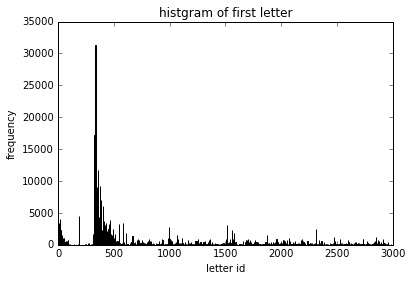

In [241]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_title('histgram of first letter')
ax.set_xlabel('letter id')
ax.set_ylabel('frequency')
ax.hist(train_comment_data[:, 0], bins=3000)

In [7]:
print_sentence(train_comment_data[:30])

0 ドンキとかにも売ってそう<EOS>                                  
1 早口おばさんも超早口おばさんも好き<EOS>                        
2 ここきらい<EOS>                                                
3 生主の時点で駄目だろ<EOS>                                      
4 投コメ色々書きすぎで草<EOS>                                    
5 これほんとほしい 売れ(上から目線)<EOS>                      
6 発想が天才のそれ<EOS>                                          
7 嘘つけ。<EOS>                                                  
8 雰囲気ぶち壊しのBGMでこれもうわかんねえな<EOS>              
9 ドラえもんのび太と妖精の国の駅のステージのBGMに似てる<EOS>  
10 嫌?<EOS>                                                      
11 さんいすき<EOS>                                                
12 毎回ほほ~で草<EOS>                                            
13 水洗った?<EOS>                                                
14 EXILEは草<EOS>                                            
15 イスラム国に連れて行くぞオラァ!<EOS>                          
16 予 言 之 書<EOS>                                            
17 最後のがいらないとおもった<EOS>                                
1

## zero input sampling

In [388]:
batch_size = 30
generator.reset_state()

x = chainer.Variable(generator.xp.asanyarray([generator.start_token] * batch_size, 'int32'), volatile=True)

print_sentence(generate(30, x, T=1))

0 おしまんよ! kika<EOS>                
1 ここUHA!<EOS>                          
2 目立ねー兄弟···ふざけられ・・<EOS>      
3 びょうに差別もすごい。<EOS>                
4 ガバガバw<EOS>                            
5 これしたせえ!うぜえ<EOS>                  
6 糞参大わかんなさい・・・・<EOS>            
7 いっつりこわい<EOS>                        
8 うかました<EOS>                            
9 やっぱ身隊以外はいいと思うな<EOS>          
10 ブンキュンは低くも人間なの?<EOS>          
11 あかんさんって衰えないんだろうこと...
12 ホモの男<EOS>                              
13 すごすぎてミンスに働かけて分かるけど<EOS>  
14 III<EOS>                                
15 おお、ルイフィットかよ・・・<EOS>          
16 職人がヒトルバ造納作に車を引くんですかね
17 待ってたな<EOS>                            
18 ああ~!!<EOS>                            
19 ストランすぎて展開曲出される輩きた<EOS>    
20 イー安豆、この騙された!!もういいぞ!!
21 タグレデス<EOS>                            
22 よく説明しろや<EOS>                        
23 テロ目の方がキャラか<EOS>                  
24 出力な<EOS>                                
25 ↓予告聞いた人だー?<EOS>                  
26 えぃ、きつからやりたかったのは!<EOS>      
27 BUMブライブア~皿<EOS>                  
28

## zero inputの1文字目の分布

<Container object of 3000 artists>

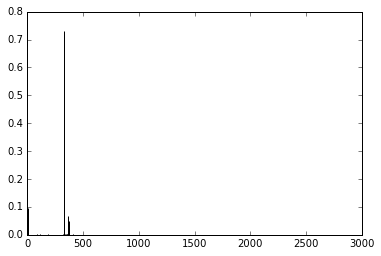

In [109]:
T = 1
batch_size = 1
generator.reset_state()
x = chainer.Variable(generator.xp.asanyarray([generator.start_token] * batch_size, 'int32'), volatile=True)

scores = generator.decode_one_step(x, False)
pred = softmax(cuda.to_cpu(scores.data), T)

plt.bar(np.arange(3000),  pred[0])

In [145]:
[ vocab[i] for i in np.argsort(-pred[0])[:10]]

['こ', 'お', 'あ', 'な', 'う', 'い', 'ま', 'そ', 'や', 'ア']

## こ、おを抜いてみた

<Container object of 2998 artists>

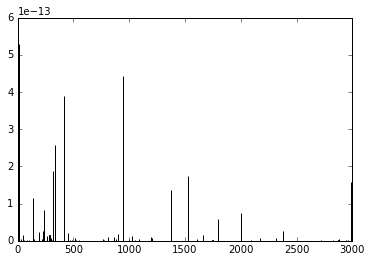

In [23]:
ind_rm = [np.argsort(-pred[0])[:2]]
ind = np.ones(3000, dtype=bool)
ind[ind_rm] = False
plt.bar(np.arange(3000-2),  pred[0][ind])

## 温度下げてみた

<Container object of 3000 artists>

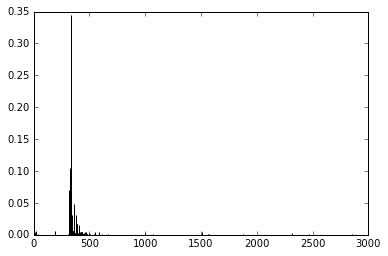

In [11]:
T = 0.5
batch_size = 1
generator.reset_state()
x = chainer.Variable(generator.xp.asanyarray([generator.start_token] * batch_size, 'int32'), volatile=True)

scores = generator.decode_one_step(x, False)
pred = softmax(cuda.to_cpu(scores.data), T)
plt.bar(np.arange(3000),  pred[0])

## random noize inputの1文字目の分布

In [ ]:
T = 1
batch_size = 10
generator.reset_state()

random_noize = np.random.normal(scale=1, size=(batch_size, generator.emb_dim))
generator.lstm1.h = chainer.Variable(generator.xp.asanyarray(random_noize, 'float32'), volatile=True)

x = chainer.Variable(generator.xp.asanyarray([generator.start_token] * batch_size, 'int32'), volatile=True)

scores = generator.decode_one_step(x, False)
pred = softmax(cuda.to_cpu(scores.data), T)
for i in range(batch_size):
    plt.bar(np.arange(3000),  pred[i])
    plt.show()

## const random noize sampling

In [87]:
batch_size = 30
generator.reset_state()

rand = np.zeros((30, generator.emb_dim))
rand[:] = z#np.random.normal(scale=1, size=generator.emb_dim)
generator.lstm1.h = chainer.Variable(generator.xp.asanyarray(rand, 'float32'), volatile=True)

x = chainer.Variable(generator.xp.asanyarray([generator.start_token] * batch_size, 'int32'), volatile=True)

print_sentence(generate(30, x))

0 おの係緒い)<EOS>                                              
1 おわムキどー<EOS>                                              
2 おなの(ふ)<EOS>                                              
3 おのぶったw<EOS>                                              
4 おのブラ」w<EOS>                                              
5 ́の係や?<EOS>                                                
6 おの醒だw)<EOS>                                              
7 おいのやめろ<EOS>                                              
8 おのわかるw<EOS>                                              
9 おいキグ?<EOS>                                                
10 おの章だっ!<EOS>                                              
11 おの嫁w()<EOS>                                              
12 おのPだっ!<EOS>                                              
13 おのおったw<EOS>                                              
14 おー応キロ)<EOS>                                              
15 おwwム(歓<EOS>                                              
16 お銀のゃキw<EOS>                  

## random noize sampling

In [21]:
tag_.shape

(60, 6)

In [455]:
randominput = generator.generate(30, random_state=True)
for i, x in enumerate(randominput):
    print(i, (''.join([vocab[w] for w in x])))

# generator.reset_state()
# z = chainer.Variable(generator.xp.asanyarray(np.random.normal(scale=1, size=(60, generator.emb_dim)), 'float32'), volatile=True)
# tag_batch = np.repeat(range(len(tag_id)), 10)
# tag_ = generator.tag_embed(chainer.Variable(generator.xp.array(tag_batch, 'int32'), volatile=True))
# generator.lstm1.h = generator.dec_input(F.concat((z, tag_)))

# x = chainer.Variable(generator.xp.asanyarray([generator.start_token] * 60, 'int32'), volatile=True)

# sentences = generate(60, x, T=1)
# for x,y in zip(tag_batch, to_sentence(sentences)):
#     print(tag_id[x], y)

0 こくいな毛<EOS>                                                
1 「皮をのぺい暗黒だ・・<EOS>                                    
2 そっけに責いするアー<EOS>                                      
3 皆ん パス最1?<EOS>                                          
4 突え的員が多だ<EOS>                                            
5 見づなボスのブだ<EOS>                                          
6 うん特好さモン<EOS>                                            
7 みこは倉弁の木読ではwoue」<EOS>                            
8 (お信<EOS>                                                    
9 漢を値にんだな新も)<EOS>                                      
10 (°マ な国の左翼こで何草<EOS>                                
11 反町・大式ア嵐<EOS>                                            
12 レチに在っろの分がさま!<EOS>                                  
13 泣の荒らハギ回w<EOS>                                          
14 ほしー言やまるな<EOS>                                          
15 諸安好いお祈ぁお少ない、ww<EOS>                              
16 イミのせー<EOS>                                                
17 朝も1のデミ<EOS>        

## random noize argmax

In [398]:
batch_size = 30
generator.reset_state()

# random_noize = np.random.normal(scale=3, size=(batch_size, generator.emb_dim))
generator.lstm1.h = chainer.Variable(generator.xp.asanyarray(random_noize, 'float32'), volatile=True)

x = chainer.Variable(generator.xp.asanyarray([generator.start_token] * batch_size, 'int32'), volatile=True)

print_sentence(generate(batch_size, x, sampling=False))

0 葉がご細しら飽誕で!ww<EOS>                                  
1 本代聞なにいた<EOS>                                            
2 ♡みの                                                      
3 男ーまむ<EOS>                                                  
4 拐<EOS>                                                        
5 々けけんろっとんでなろで<EOS>                                  
6 色空蓮ィ)なせよノイ色参応那ヴ・・?<EOS>                      
7 っか<EOS>     “?"👽👽    <EOS>                                
8 取、れそー歌猫イ誰み』<EOS>                                    
9 込ーばキャフャチル眼撃みなな<EOS>                              
10 てたう方差ザよいいい格格稼ぎがないんんっけんんだろない<EOS>    
11     定少の<EOS>                                                
12 済<EOS>                                                        
13 てゃ帰と?親座に来たなwh<EOS>                                
14 要出ばまじガグ5決上去いなよなーw<EOS>                        
15 野ェパリ<EOS>                                                  
16 ょ西人な作ふゾ<EOS>                                            
17 摘<EOS>    な  w<EOS>           

## random noizeで1文字目に強制挿入

In [458]:
batch_size = 30
generator.reset_state()

random_noize = np.random.normal(scale=1, size=(batch_size, generator.emb_dim))
generator.lstm1.h = chainer.Variable(generator.xp.asanyarray(random_noize, 'float32'), volatile=True)

x = chainer.Variable(generator.xp.asanyarray([generator.start_token] * batch_size, 'int32'), volatile=True)

const_random = np.zeros((batch_size, generator.sequence_length), 'int32')
for i in range(generator.sequence_length):
    scores = generator.decode_one_step(x, False)
    pred = softmax(cuda.to_cpu(scores.data), T=1)
    if i == 0:
#         generated = [np.random.choice(generator.vocab_size, p=pred[j]) for j in range(batch_size)]
#         generated = [np.argsort(-pred[0])[0] for j in range(batch_size)]
        generated = [493] * batch_size
    else:
        generated = [np.argmax(pred[j]) for j in range(batch_size)]

    const_random[:, i] = generated
    x = chainer.Variable(generator.xp.asanyarray(generated, 'int32'), volatile=True)

print_sentence(const_random)


0 一スムが救まっ<EOS>                                            
1 一のぱか<EOS>                                                  
2 一お〜 って ーラだー<EOS>                                    
3 一形ダルをすよ<EOS>                                            
4 一住は主義のにいw<EOS>                                        
5 一度らで草<EOS>                                                
6 一な.<EOS>                                                    
7 一為はタイヤッたわ<EOS>                                        
8 一まで添いたいもよ<EOS>                                        
9 一の広動だいて~か<EOS>                                        
10 一つやにダレw<EOS>                                            
11 一は焼いすふ<EOS>                                              
12 一まけ怖之<EOS>                                                
13 一匹なぁ<EOS>                                                  
14 一あ? ジろーw<EOS>                                          
15 一回者うぷっだろ<EOS>                                          
16 一素ってあだわ<EOS>                                  

In [411]:
vocab.index('一')

493

## Encoderによるzの分布

In [143]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [160]:
positive = train_comment_data[np.random.permutation(train_num)[:10000]]
# sentences = to_sentence(positive)
_, mu_z, ln_var_z = encoder.encode(positive)
F.gaussian_kl_divergence(mu_z, ln_var_z).data / 10000
mu = cuda.to_cpu(mu_z.data)

array(128.89439392089844, dtype=float32)

(array([  3.50000000e+01,   2.04200000e+03,   5.32250000e+04,
          4.58612000e+05,   1.89062800e+06,   1.45606000e+05,
          9.61000000e+03,   2.32000000e+02,   8.00000000e+00,
          2.00000000e+00]),
 array([-4.79211426, -3.65199394, -2.51187363, -1.37175331, -0.231633  ,
         0.90848732,  2.04860764,  3.18872795,  4.32884827,  5.46896858,
         6.6090889 ]),
 <a list of 10 Patch objects>)

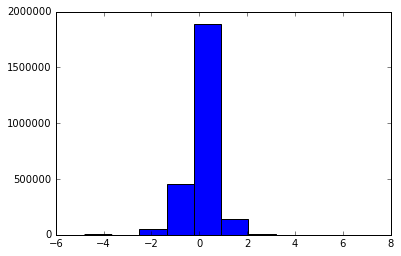

In [162]:
plt.hist(mu.ravel())

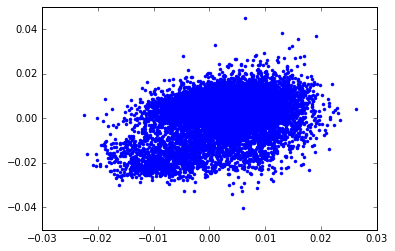

In [44]:
plt.plot(mu[:, 0],mu[:,1], ".")

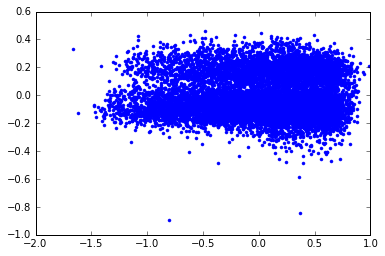

In [45]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(mu)
plt.plot(pca_result[:, 0], pca_result[:,1], '.')

In [163]:
model = TSNE(n_components=2)
tsne_result = model.fit_transform(cuda.to_cpu(mu_z.data))
plt.plot(tsne_result[:,0], tsne_result[:,1], ".")

KeyboardInterrupt: 

## Reconstruction

In [10]:
generator.reset_state()
batch_size = 30
T =1
sampling=False
positive = train_comment_data[np.random.permutation(train_num)[:batch_size]]
# sentences = to_sentence(positive)
_, mu_z, ln_var_z = encoder.encode(positive, train=False)

z = F.gaussian(mu_z, ln_var_z)
generator.lstm1.h = z
x = chainer.Variable(generator.xp.asanyarray([generator.start_token] * batch_size, 'int32'), volatile=True)

const_random = np.zeros((batch_size, generator.sequence_length), 'int32')
for i in range(generator.sequence_length):
    scores = generator.decode_one_step(x, train=False)
    pred = softmax(cuda.to_cpu(scores.data), T)
    if sampling:
        generated = [np.random.choice(generator.vocab_size, p=pred[j]) for j in range(batch_size)]
    else:
        generated = [np.argmax(pred[j]) for j in range(batch_size)]

    const_random[:, i] = generated
    x = chainer.Variable(generator.xp.asanyarray(generated, 'int32'), volatile=True)

a = to_sentence(positive)
b = to_sentence(const_random)

for i, (aa, bb) in enumerate(zip(a,b)):
    print(i, aa.rstrip().ljust(30,'　'),bb)

0 イケボ<EOS>　　　　　　　　　　　　　　　　　　　　　　 イケボ<EOS>                                                    
1 ほとんどモロ出しディックすき<EOS>　　　　　　　　　　　 ほしょどん安出とディックすき<EOS>                              
2 エジプト新王国(B.C.14世紀)<EOS>　　　　　　　　 エジプト新王国(B.9.14世紀)<EOS>                        
3 カカカタ☆カタオモイ<EOS>　　　　　　　　　　　　　　　 カカカタ☆カタオツイ<EOS>                                      
4 いやいやwww<EOS>　　　　　　　　　　　　　　　　　　 いやいやwww<EOS>                                            
5 おしいい<EOS>　　　　　　　　　　　　　　　　　　　　　 おしいい<EOS>                                                  
6 (114514?)<EOS>　　　　　　　　　　　　　　　　 (1145144)<EOS>                                        
7 らん<EOS>　　　　　　　　　　　　　　　　　　　　　　　 らん<EOS>                                                      
8 🍅🍅🍅🍅🍅🍅🍅<EOS>　　　　　　　　　　　　　　　　　　 🍅🍅🍅🍅🍅🍅🍅<EOS>                                            
9 すねおって優しい人なんだ。ほほう。<EOS>　　　　　　　　 すねおして優しい人なんだ。ほほう。<EOS>                        
10 羽生くん美しいなぁ<EOS>　　　　　　　　　　　　　　　　 羽生くん美しいなぁ<EOS>                                        
11 いくで<EOS>　　　　　　　　　　　　　　　　　　　　

## Encodeされたzの周り

In [30]:
generator.reset_state()
batch_size = 30
T =1
sampling=True
positive = train_comment_data[np.random.permutation(train_num)[:1]]
a = to_sentence(positive)
print(a[0])

# sentences = to_sentence(positive)
_, mu_z, ln_var_z = encoder.encode(positive, train=False)

rand = np.zeros((batch_size, generator.emb_dim))
for i in range(batch_size):
    rand[i] = np.random.normal(loc=cuda.to_cpu(mu_z.data), scale=0.5, size=generator.emb_dim)

generator.reset_state()
generator.lstm1.h = chainer.Variable(generator.xp.asanyarray(rand, 'float32'), volatile=True)
x = chainer.Variable(generator.xp.asanyarray([generator.start_token] * batch_size, 'int32'), volatile=True)

print_sentence(generate(batch_size, x, sampling=True))

エンリピしまああああす<EOS>                                    
0 エンリピしすああああん<EOS>                                    
1 エーリピしまあああ、し<EOS>                                    
2 エンロピしあうあます<EOS>                                      
3 エンリバしまあれw<EOS>                                        
4 エーリピしまりますああああんし<EOS>                            
5 エンリバしまあほえ<EOS>                                        
6 エンリピクあまああ<EOS>                                        
7 エンロピしますああた<EOS>                                      
8 エン路固タめあまあ行って<EOS>                                  
9 エンリピしまああああ<EOS>                                      
10 キンゥピしまあああいます<EOS>                                  
11 エンリ固しまああああ<EOS>                                      
12 エンリピしましあすあああす<EOS>                                
13 エンリピしああああ<EOS>                                        
14 エンロあしあ<EOS>                                              
15 エンリピしかあうあ<EOS>                                        
16 エンリピしの固定ああまあすし<EOS>                            

## 内分点

In [56]:
generator.reset_state()
batch_size = 11
T =1
sampling=False
positive = train_comment_data[np.random.permutation(train_num)[:2]]
# sentences = to_sentence(positive)
_, mu_z, ln_var_z = encoder.encode(positive, train=False)

z1 = cuda.to_cpu(mu_z.data[0])
z2 = cuda.to_cpu(mu_z.data[1])

z = np.zeros((11, generator.emb_dim))
for t in range(0,11):
    t_ = t*0.1
    z[t] = (1-t_)*z1 + t_*z2
    
generator.lstm1.h = chainer.Variable(generator.xp.asanyarray(z, 'float32'), volatile=True)
x = chainer.Variable(generator.xp.asanyarray([generator.start_token] * batch_size, 'int32'), volatile=True)

a = to_sentence(positive)    
b = to_sentence(generate(batch_size, x, sampling=True))
print(a[0], end='\n\n')
for i, bb in enumerate(b):
    print(i, bb)
print('\n'+a[1])

不正はなかった<EOS>                                            

0 不正はなかった<EOS>                        
1 不正はなかった<EOS>                        
2 不正はなかった<EOS>                        
3 不正はなかった<EOS>                        
4 不正はなかった<EOS>                        
5 不正がえないっかたあ<EOS>                  
6 なあかヤばなどかったw<EOS>                
7 なんがヤばれるからの草<EOS>                
8 なんかヤスれうなのがたw<EOS>              
9 なんがヤバそうなのか来たw<EOS>            
10 なんかヤバそうなのが来たw<EOS>            

なんかヤバそうなのが来たw<EOS>                                


## すべてのコメントをencode

In [7]:
perm = np.random.permutation(len(train_comment_data))
positive = train_comment_data[perm[:100000]]

comment_space = np.vstack([cuda.to_cpu(encoder.encode(positive[i:i+1000], train=False)[1].data) for i in range(0, len(positive), 1000)])

test_x = np.zeros((100000, 256))
for i in range(len(comment_space)):
    test_x[i] = comment_space[i] / np.linalg.norm(comment_space[i])

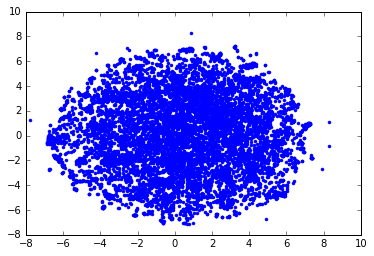

In [9]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2)
tsne_result = model.fit_transform(comment_space[:10000])
plt.plot(tsne_result[:,0], tsne_result[:,1], ".")

## あるコメントからz空間上でcos類似度がちかいもの　

In [24]:
n = np.random.randint(100000)
print(to_sentence([positive[n]])[0] + '\n')
T = 1
sampling = True
z = test_x[n]
indices = np.argsort(-np.dot(z, test_x.T))[:20]

batch_size = 20
generator.reset_state()
generator.lstm1.h = chainer.Variable(generator.xp.asanyarray(comment_space[indices], 'float32'), volatile=True)
x = chainer.Variable(generator.xp.asanyarray([generator.start_token] * batch_size, 'int32'), volatile=True)

const_random = np.zeros((batch_size, generator.sequence_length), 'int32')
for i in range(generator.sequence_length):
    scores = generator.decode_one_step(x, train=False)
    pred = softmax(cuda.to_cpu(scores.data), T)
    if sampling:
        generated = [np.random.choice(generator.vocab_size, p=pred[j]) for j in range(batch_size)]
    else:
        generated = [np.argmax(pred[j]) for j in range(batch_size)]

    const_random[:, i] = generated
    x = chainer.Variable(generator.xp.asanyarray(generated, 'int32'), volatile=True)

    
print_sentence(const_random)


鼻声?<EOS>                                                    

0 鼻声?<EOS>                                                    
1 鼻声<EOS>                                                      
2 鼻声<EOS>                                                      
3 鼻声だね<EOS>                                                  
4 鼻ww<EOS>                                                    
5 鼻水?<EOS>                                                    
6 鼻が<EOS>                                                      
7 鼻か<EOS>                                                      
8 鼻歌w<EOS>                                                    
9 鼻汁<EOS>                                                      
10 鼻でか<EOS>                                                    
11 奇声<EOS>                                                      
12 鼻低くなった?<EOS>                                            
13 ドブ...<EOS>                                                
14 ほー?<EOS>                                          

## random noizeから近いコメント

In [58]:
z = np.random.normal(scale=1, size=256)
z /= np.linalg.norm(z)
indices = np.argsort(-np.dot(z, test_x.T))[:20]

batch_size = 20
generator.reset_state()
generator.lstm1.h = chainer.Variable(generator.xp.asanyarray(comment_space[indices], 'float32'), volatile=True)
x = chainer.Variable(generator.xp.asanyarray([generator.start_token] * batch_size, 'int32'), volatile=True)

const_random = np.zeros((batch_size, generator.sequence_length), 'int32')
for i in range(generator.sequence_length):
    scores = generator.decode_one_step(x, train=False)
    pred = softmax(cuda.to_cpu(scores.data), T)
    if sampling:
        generated = [np.random.choice(generator.vocab_size, p=pred[j]) for j in range(batch_size)]
    else:
        generated = [np.argmax(pred[j]) for j in range(batch_size)]

    const_random[:, i] = generated
    x = chainer.Variable(generator.xp.asanyarray(generated, 'int32'), volatile=True)
print_sentence(const_random)

0 ヴァーカタレがっ!<EOS>                                        
1 じわーり<EOS>                                                  
2 おー!おめでとです<EOS>                                        
3 杯が終わってから誰やる動けどって事も居るね<EOS>                
4 コナン映画最高傑作だよなあ?<EOS>                              
5 ちゃんと顔モザ入れてて好き感じるね!<EOS>                      
6 ごはんやだな<EOS>                                              
7 動作できんかったかw<EOS>                                      
8 SA-YO-NA-RA w<EOS>                                
9 皆機嫌悪そうに見えるwww<EOS>                                
10 じわる<EOS>                                                    
11 じわる<EOS>                                                    
12 ぴったり<EOS>                                                  
13 ふぁんたじー<EOS>                                              
14 ふぇんりる<EOS>                                                
15 左は走行車線で別が追い越しま線でからこれいいんだよなあ<EOS>    
16 あのスケジュールじゃき機好きさせるともこないんですかな?<EOS>  
17 やかんあれ火の中にでも放送り込んだ??<EOS>                    
18 スジ彫りちょっと多い感じも

## tag 利用

In [6]:
tag_batch = np.repeat(range(len(tag_id)), 5)
negative = generator.generate_use_tag(tag_batch, train=True)

AttributeError: 'SeqGAN' object has no attribute 'tag_embed'

In [10]:
for a,b in zip(tag_batch, to_sentence(negative)):
    print(tag_id[a], '         ', b)

NameError: name 'negative' is not defined

In [ ]:
generator.reset_state()

batch_size = 60
T = 1
sampling=True
train = False

positive = train_comment_data[np.random.permutation(train_num)[:60]]

tag_batch = np.repeat(range(len(tag_id)), 10)
tag_ = generator.tag_embed(chainer.Variable(generator.xp.array(tag_batch, 'int32'), volatile=True))

_, mu_z, ln_var_z = encoder.encode_with_tag(positive, tag_batch, train)
z = F.gaussian(mu_z, ln_var_z)

generator.lstm1.h = generator.dec_input(F.concat((z, tag_)))

x = chainer.Variable(generator.xp.asanyarray([generator.start_token] * batch_size, 'int32'), volatile=True)

const_random = np.zeros((batch_size, generator.sequence_length), 'int32')
for i in range(generator.sequence_length):
    scores = generator.decode_one_step(x, train=False)
    pred = softmax(cuda.to_cpu(scores.data), T)
    if sampling:
        generated = [np.random.choice(generator.vocab_size, p=pred[j]) for j in range(batch_size)]
    else:
        generated = [np.argmax(pred[j]) for j in range(batch_size)]

    const_random[:, i] = generated
    x = chainer.Variable(generator.xp.asanyarray(generated, 'int32'), volatile=True)

a = to_sentence(positive)
b = to_sentence(const_random)

for i, aa, bb in zip(tag_batch, a,b):
    print(tag_id[i], aa,bb)